### $\bullet\;Import\;Libraries$

In [ ]:
%pip install torchmetrics
%pip install torchview

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
import torch
import torch.nn             as nn
import torch.optim          as optim
import torch.nn.functional  as F
import torch.backends.cudnn as cudnn
import torchvision
import matplotlib.pyplot    as plt
import numpy                as np
import pandas               as pd
import os
import pickle

from torch.utils.data       import TensorDataset, DataLoader, random_split
from torchvision            import transforms
from torchvision.datasets   import CIFAR10
from torchmetrics           import Accuracy
from tqdm                   import tqdm
from torch.utils.data       import Dataset
from PIL                    import Image
from math                   import sqrt

from torchview import draw_graph
from IPython.display import Image, display

plt.style.use('grayscale')

### $\bullet\;CIFAR\;Dataset$

#### $Load\;Dataset$

In [ ]:
dataset = CIFAR10(root='./cifar10', train=True, download=True, transform=transforms.ToTensor())

loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False, num_workers=2)
data_iter = iter(loader)
images, _ = next(data_iter)

mean = images.mean(dim=[0, 2, 3])
std = images.std(dim=[0, 2, 3])

print("Mean per channel :", mean)
print("Std per channel  :", std)

In [ ]:
transform   = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])])

train_set   = CIFAR10(root='./cifar10', train=True , download=True, transform=transform)
test_set    = CIFAR10(root='./cifar10', train=False, download=True, transform=transform)

#### $Train\;set-Test\;set\;Classes$

In [ ]:
pd.DataFrame(train_set.class_to_idx.items(), columns=['Class Name', 'Class Index']).style.hide()

In [ ]:
pd.DataFrame(train_set.class_to_idx.items(), columns=['Class Name', 'Class Index']).style.hide()

Class Name,Class Index
airplane,0
automobile,1
bird,2
cat,3
deer,4
dog,5
frog,6
horse,7
ship,8
truck,9


In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val    = 0
        self.avg    = 0
        self.sum    = 0
        self.count  = 0

    def update(self, val, n=1):
        self.val    = val
        self.sum    += val * n
        self.count  += n
        self.avg    = self.sum / self.count

### $\bullet\;$ CIFAR10 DataLoader, Visualization

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-8-9c4e67c9934c>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean).view(3, 1, 1)
<ipython-input-8-9c4e67c9934c>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std).view(3, 1, 1)


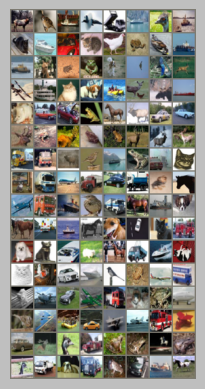

In [ ]:
# DataLoader
trainloader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False, num_workers=4)

def denormalize(img, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return img * std + mean

# Show one batch of images
dataiter = iter(trainloader)
images, labels = next(dataiter)
img_grid = torchvision.utils.make_grid(images)
img_grid = denormalize(img_grid, mean, std)
plt.imshow(img_grid.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
plt.show()

### $\bullet\;$ CNN Model

model size: 38021440 bit | 4.75 MB


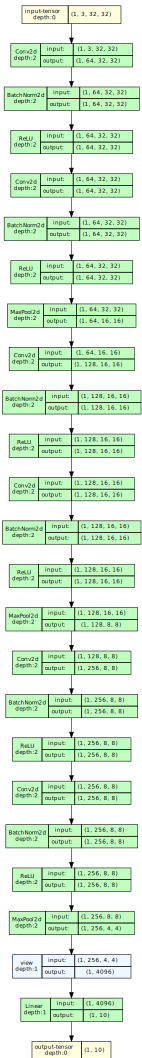

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 7 layers total: 6 conv + final classifier
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            # Block 2
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            # Block 3
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(256 * 4 * 4, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = CNN()
batch_size = 2
size_model = 0
for param in model.parameters():
    if param.data.is_floating_point():
        size_model += param.numel() * torch.finfo(param.data.dtype).bits
    else:
        size_model += param.numel() * torch.iinfo(param.data.dtype).bits
print(f"model size: {size_model} bit | {size_model / 8e6:.2f} MB")

model_graph = draw_graph(model, input_size=(1, 3, 32, 32), device='meta')
display(model_graph.visual_graph)

In [ ]:
def print_layer_outputs(model, input_size):
    x = torch.randn(input_size)
    print(f"Input: {x.shape}")
    count = 0
    for i, layer in enumerate(model.features):
        x = layer(x)
        if layer.__class__.__name__ in ['Conv2d']:
            count += 1
        print(f"Layer {count} ({layer.__class__.__name__}): {x.shape}")
    x = x.view(x.size(0), -1)
    print(f"Flatten: {x.shape}")
    x = model.classifier(x)
    print(f"Classifier Output: {x.shape}")

model = CNN().to('cpu')
print_layer_outputs(model, (1, 3, 32, 32))

Input: torch.Size([1, 3, 32, 32])
Layer 1 (Conv2d): torch.Size([1, 64, 32, 32])
Layer 1 (BatchNorm2d): torch.Size([1, 64, 32, 32])
Layer 1 (ReLU): torch.Size([1, 64, 32, 32])
Layer 2 (Conv2d): torch.Size([1, 64, 32, 32])
Layer 2 (BatchNorm2d): torch.Size([1, 64, 32, 32])
Layer 2 (ReLU): torch.Size([1, 64, 32, 32])
Layer 2 (MaxPool2d): torch.Size([1, 64, 16, 16])
Layer 3 (Conv2d): torch.Size([1, 128, 16, 16])
Layer 3 (BatchNorm2d): torch.Size([1, 128, 16, 16])
Layer 3 (ReLU): torch.Size([1, 128, 16, 16])
Layer 4 (Conv2d): torch.Size([1, 128, 16, 16])
Layer 4 (BatchNorm2d): torch.Size([1, 128, 16, 16])
Layer 4 (ReLU): torch.Size([1, 128, 16, 16])
Layer 4 (MaxPool2d): torch.Size([1, 128, 8, 8])
Layer 5 (Conv2d): torch.Size([1, 256, 8, 8])
Layer 5 (BatchNorm2d): torch.Size([1, 256, 8, 8])
Layer 5 (ReLU): torch.Size([1, 256, 8, 8])
Layer 6 (Conv2d): torch.Size([1, 256, 8, 8])
Layer 6 (BatchNorm2d): torch.Size([1, 256, 8, 8])
Layer 6 (ReLU): torch.Size([1, 256, 8, 8])
Layer 6 (MaxPool2d): to

### $\bullet\;$ Train

#### loss, optimizer, scheduler

using CrossEntropyLoss

using Adam with lr=0.001, weight_decay=1e-4

In [ ]:
# Select device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)

# loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)

In [12]:
# Training loop with loss tracking
epochs = 20
train_accs, test_accs, train_losses, test_losses = [], [], [], []
for epoch in range(1, epochs+1):
    model.train()
    correct, total = 0, 0
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(trainloader, 1):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        _, preds = outputs.max(1)
        total += targets.size(0)
        correct += preds.eq(targets).sum().item()
        running_loss += loss.item() * inputs.size(0)
    train_accs.append(100.*correct/total)
    train_losses.append(running_loss / total)

    model.eval()
    correct, total = 0, 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            total += targets.size(0)
            correct += preds.eq(targets).sum().item()
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
    test_acc = 100. * correct / total
    test_losses.append(running_loss / total)
    test_accs.append(test_acc)
    scheduler.step()
    print(f"Epoch {epoch:2d}: Train Acc = {train_accs[-1]:.2f}%, Test Acc = {test_acc:.2f}%")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  1: Train Acc = 54.88%, Test Acc = 66.27%
Epoch  2: Train Acc = 74.10%, Test Acc = 75.72%
Epoch  3: Train Acc = 80.67%, Test Acc = 74.45%
Epoch  4: Train Acc = 84.65%, Test Acc = 79.36%
Epoch  5: Train Acc = 88.39%, Test Acc = 82.22%
Epoch  6: Train Acc = 91.10%, Test Acc = 83.46%
Epoch  7: Train Acc = 93.95%, Test Acc = 82.03%
Epoch  8: Train Acc = 96.22%, Test Acc = 83.72%
Epoch  9: Train Acc = 98.12%, Test Acc = 83.45%
Epoch 10: Train Acc = 99.10%, Test Acc = 85.81%
Epoch 11: Train Acc = 99.70%, Test Acc = 86.86%
Epoch 12: Train Acc = 99.96%, Test Acc = 86.83%
Epoch 13: Train Acc = 100.00%, Test Acc = 87.72%
Epoch 14: Train Acc = 100.00%, Test Acc = 87.80%
Epoch 15: Train Acc = 100.00%, Test Acc = 87.84%
Epoch 16: Train Acc = 100.00%, Test Acc = 87.98%
Epoch 17: Train Acc = 100.00%, Test Acc = 87.83%
Epoch 18: Train Acc = 100.00%, Test Acc = 87.72%
Epoch 19: Train Acc = 100.00%, Test Acc = 87.85%
Epoch 20: Train Acc = 100.00%, Test Acc = 87.94%


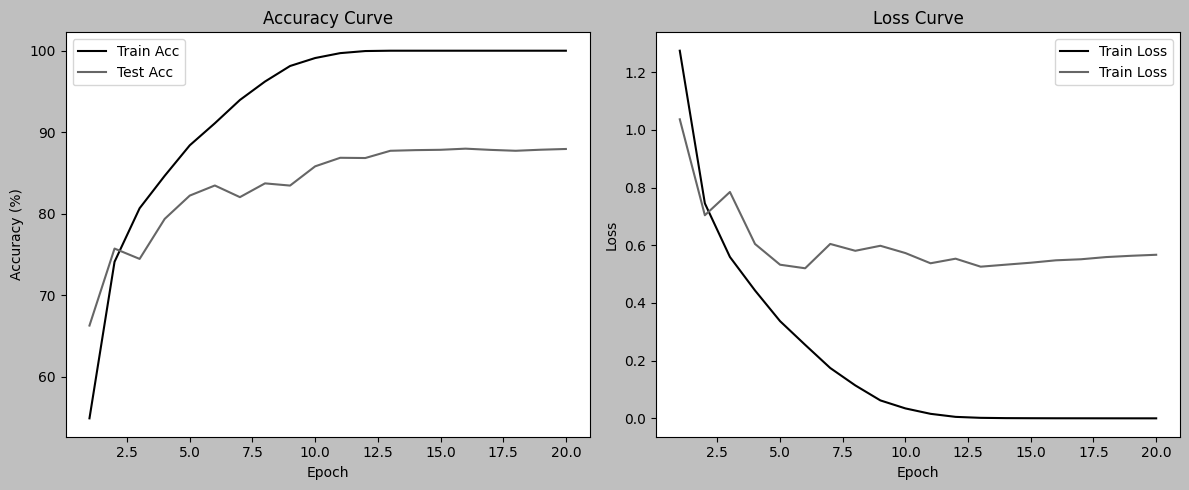

In [13]:
# Plot accuracy and loss curves
eps = range(1, epochs+1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(eps, train_accs, label='Train Acc')
plt.plot(eps, test_accs, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curve')

plt.subplot(1,2,2)
plt.plot(eps, train_losses, label='Train Loss')
plt.plot(eps, test_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.tight_layout()
plt.show()

# Phase 2

In [14]:
import copy
import torch.nn.utils.prune as prune

baseline_model = copy.deepcopy(model)

In [31]:
def test(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return 100.*correct/total

## Q1-بررسی هرس یکباره

ابتدا از روش کاملا تصادفی استفاده می کنیم. در این روش بدون توجه به هیچ چیزی شروع به هرس می کنیم و برایمان تفاوتی بین وزن ها و یال ها وجود ندارد.

Random unstructured prune 20%, acc: 27.68%
Random unstructured prune 30%, acc: 15.92%
Random unstructured prune 40%, acc: 14.36%
Random unstructured prune 50%, acc: 10.08%
Random unstructured prune 60%, acc: 12.75%
Random unstructured prune 70%, acc: 10.00%
Random unstructured prune 80%, acc: 10.00%


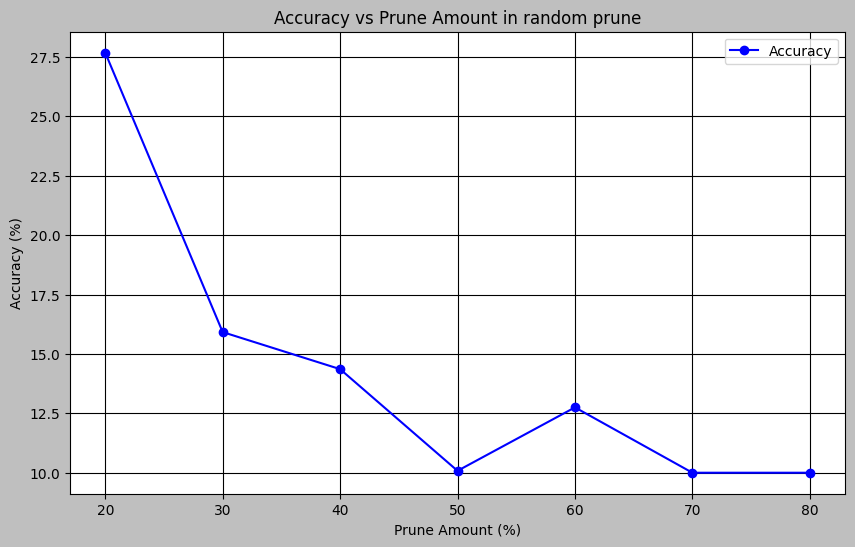

In [16]:
import matplotlib.pyplot as plt

pruned_models = []
prune_amounts = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
accuracies = []

for amount in prune_amounts:
    model_copy = copy.deepcopy(baseline_model)
    for module in model_copy.modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            prune.random_unstructured(module, name='weight', amount=amount)
    pruned_models.append(model_copy)
    acc = test(model_copy)
    accuracies.append(acc)
    print(f'Random unstructured prune {amount*100:.0f}%, acc: {acc:.2f}%')

plt.figure(figsize=(10, 6))
plt.plot([amount * 100 for amount in prune_amounts], accuracies, marker='o', linestyle='-', color='b', label='Accuracy')
plt.xlabel('Prune Amount (%)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Prune Amount in random prune')
plt.grid(True)
plt.legend()
plt.show()

همانطور که انتظار داشتیم این روش اصلا مناسب نیست و از همان ابتدا دقت مدل را نصف می کند

حال از l1_unstructured استفاده می کنیم که در این روش وزن هایی که قدر مطلق آنها به صفر نزندیک تر است حذف می شود. در مقابل آن l2 رو داریم که به جای قدر مطلق از توان ۲
استفاده می کند

Random unstructured prune 20%, acc: 87.57%
Random unstructured prune 30%, acc: 86.43%
Random unstructured prune 40%, acc: 80.69%
Random unstructured prune 50%, acc: 71.16%
Random unstructured prune 60%, acc: 42.46%
Random unstructured prune 70%, acc: 25.22%
Random unstructured prune 80%, acc: 15.59%


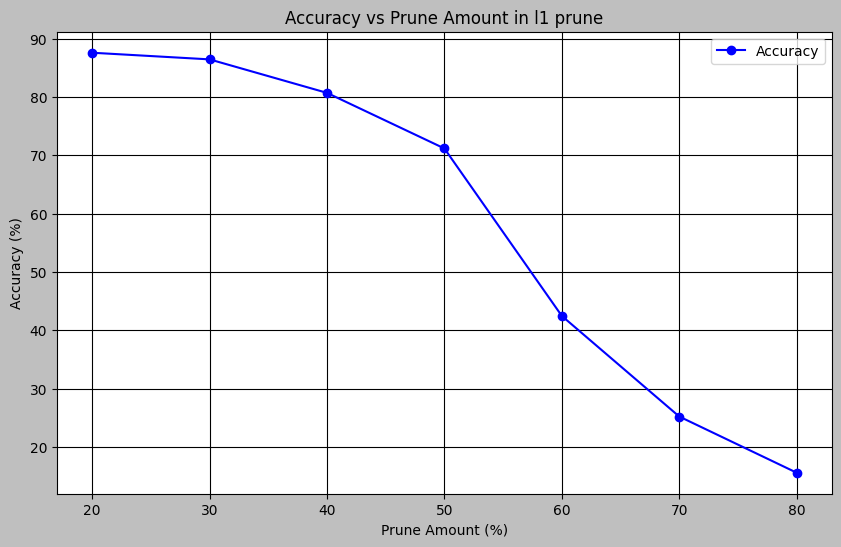

In [17]:
pruned_models = []
prune_amounts = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
accuracies = []

for amount in prune_amounts:
    model_copy = copy.deepcopy(baseline_model)
    for module in model_copy.modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=amount)
    pruned_models.append(model_copy)
    acc = test(model_copy)
    accuracies.append(acc)
    print(f'Random unstructured prune {amount*100:.0f}%, acc: {acc:.2f}%')

plt.figure(figsize=(10, 6))
plt.plot([amount * 100 for amount in prune_amounts], accuracies, marker='o', linestyle='-', color='b', label='Accuracy')
plt.xlabel('Prune Amount (%)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Prune Amount in l1 prune')
plt.grid(True)
plt.legend()
plt.show()

همانطور که در نمودار مشخص است هرس تا ۲۰ درصد تقریبا بی تاثیر است ولی باقی موارد بیش از ۱ درصد تاثیر دارند که مناسب نیست و همچنین افت دقت شدیدی بعد از حذف ۶۰ درصد شامل هستیم که دقت نصف شده

باید توجه کرد که در این روش ما با پیمایش روی شبکه در هر لایه به صورت جداگانه حرص انجام می دهیم. می شود با تجمیع وزن ها نیز این کار را انجام داد. از آنجایی که روش اول تصادفی است در نتیجه آن تفاوتی ایجاد نمی شود اما ممکن است در روش دوم تفاوت ایجاد کند که در ادامه بررسی می کنیم..

Random unstructured prune 20%, acc: 87.75%
Random unstructured prune 30%, acc: 87.34%
Random unstructured prune 40%, acc: 86.66%
Random unstructured prune 50%, acc: 80.75%
Random unstructured prune 60%, acc: 57.13%
Random unstructured prune 70%, acc: 33.89%
Random unstructured prune 80%, acc: 21.83%


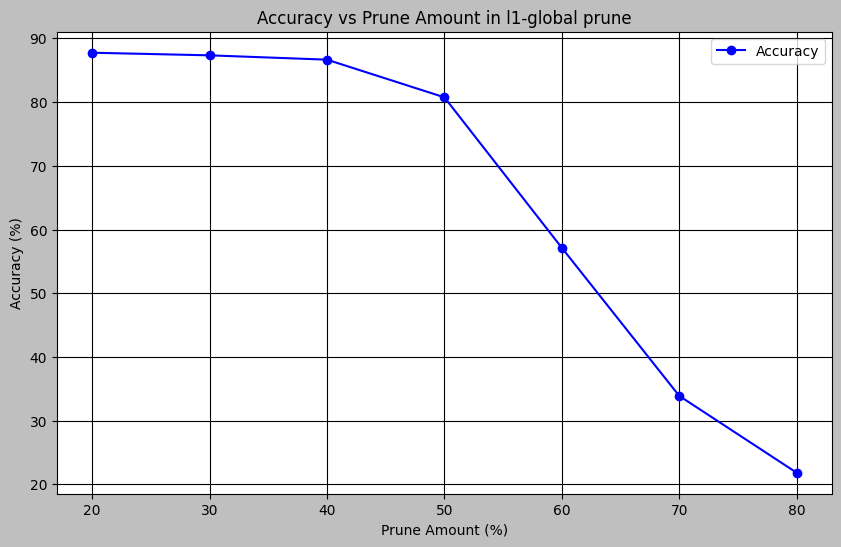

In [18]:
pruned_models = []
prune_amounts = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
accuracies = []

parameters_to_prune = []
for module in baseline_model.modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        parameters_to_prune.append((module, 'weight'))

for amount in prune_amounts:
    model_copy = copy.deepcopy(baseline_model)
    parameters = []
    for module in model_copy.modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            parameters.append((module, 'weight'))

    prune.global_unstructured(
        parameters,
        pruning_method=prune.L1Unstructured,
        amount=amount,
    )

    pruned_models.append(model_copy)
    acc = test(model_copy)
    accuracies.append(acc)
    print(f'Random unstructured prune {amount*100:.0f}%, acc: {acc:.2f}%')

plt.figure(figsize=(10, 6))
plt.plot([amount * 100 for amount in prune_amounts], accuracies, marker='o', linestyle='-', color='b', label='Accuracy')
plt.xlabel('Prune Amount (%)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Prune Amount in l1-global prune')
plt.grid(True)
plt.legend()
plt.show()

همانطور که در نمودار مشخص است با این کار تقریبا تا ۴۰ درصد حرص قابل قبول است پس با این کار تحمل مدل در حرص ۲ برابر شد

## Q2- هرس مرحله به مرحله

In [30]:
def train(epochs):
    for epoch in range(1, epochs + 1):
        model.train()
        correct, total = 0, 0
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(trainloader, 1):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            _, preds = outputs.max(1)
            total += targets.size(0)
            correct += preds.eq(targets).sum().item()
            running_loss += loss.item() * inputs.size(0)

        train_accs.append(100. * correct / total)
        train_losses.append(running_loss / total)

        model.eval()
        correct, total = 0, 0
        running_loss = 0.0
        with torch.no_grad():
            for inputs, targets in testloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, preds = outputs.max(1)
                total += targets.size(0)
                correct += preds.eq(targets).sum().item()
                loss = criterion(outputs, targets)
                running_loss += loss.item() * inputs.size(0)

        test_acc = 100. * correct / total
        test_accs.append(test_acc)
        test_losses.append(running_loss / total)
        scheduler.step()

        print(f"Epoch {epoch}/{epochs} - Train Acc: {train_accs[-1]:.2f}%, Test Acc: {test_acc:.2f}%")


Epoch 1/1 - Train Acc: 100.00%, Test Acc: 87.88%
Epoch 1/2 - Train Acc: 100.00%, Test Acc: 87.83%
Epoch 2/2 - Train Acc: 100.00%, Test Acc: 87.86%
Pruned to 20%, Accuracy: 87.86%
Epoch 1/1 - Train Acc: 100.00%, Test Acc: 87.58%
Epoch 1/2 - Train Acc: 100.00%, Test Acc: 87.68%
Epoch 2/2 - Train Acc: 100.00%, Test Acc: 87.65%
Pruned to 30%, Accuracy: 87.65%
Epoch 1/1 - Train Acc: 100.00%, Test Acc: 87.54%
Epoch 1/2 - Train Acc: 100.00%, Test Acc: 87.73%
Epoch 2/2 - Train Acc: 100.00%, Test Acc: 87.64%
Pruned to 40%, Accuracy: 87.64%
Epoch 1/1 - Train Acc: 99.92%, Test Acc: 86.49%
Epoch 1/2 - Train Acc: 99.92%, Test Acc: 86.49%
Epoch 2/2 - Train Acc: 99.92%, Test Acc: 86.43%
Pruned to 50%, Accuracy: 86.43%
Epoch 1/1 - Train Acc: 97.93%, Test Acc: 83.36%
Epoch 1/2 - Train Acc: 97.96%, Test Acc: 83.24%
Epoch 2/2 - Train Acc: 97.93%, Test Acc: 83.15%
Pruned to 60%, Accuracy: 83.15%
Epoch 1/1 - Train Acc: 91.12%, Test Acc: 78.61%
Epoch 1/2 - Train Acc: 91.25%, Test Acc: 78.41%
Epoch 2/2 - Tra

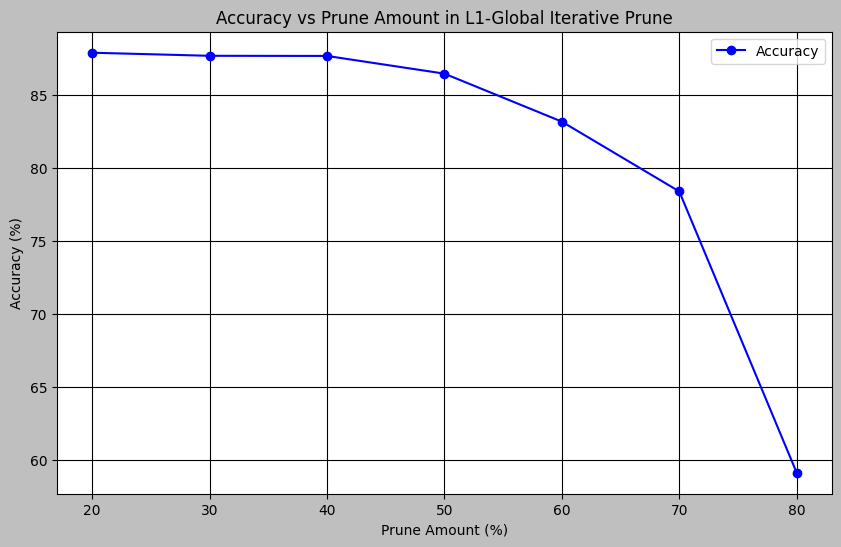

In [20]:
start_prune = 0.2
end_prune = 0.8
step_count = int((end_prune - start_prune) / 0.1) + 1
fine_tune_epochs = 3

model = copy.deepcopy(baseline_model)
parameters_to_prune = [
    (m, 'weight') for m in model.modules()
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear)
]

accuracies = []
prune_levels = []

current_pruned = 0.0
target_pruned_list = [round(p, 2) for p in list(torch.arange(start_prune, end_prune + 0.001, 0.1).tolist())]

for target in target_pruned_list:
    remaining = 1.0 - current_pruned
    step_amount = (target - current_pruned) / remaining

    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=step_amount
    )
    current_pruned = target

    for epoch in range(fine_tune_epochs):
        train(epoch)

    acc = test(model)
    accuracies.append(acc)
    prune_levels.append(target * 100)
    print(f'Pruned to {target*100:.0f}%, Accuracy: {acc:.2f}%')

plt.figure(figsize=(10, 6))
plt.plot(prune_levels, accuracies, marker='o', linestyle='-', color='b', label='Accuracy')
plt.xlabel('Prune Amount (%)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Prune Amount in L1-Global Iterative Prune')
plt.grid(True)
plt.legend()
plt.show()

با این کار دقت مدل تا ۵۰ درصد خوب است و ختی از ۴۰ درصد حالت قبلی بهتر است و همچنین دقت تمامی حالات بالا تر است مثلا در هرس ۸۰ درصد دقت ۶۳ درصد می شود در مقابل ۲۴ درصد

## Q3- هرس ساختارمند

Epoch 1/1 - Train Acc: 99.35%, Test Acc: 85.50%
Epoch 1/1 - Train Acc: 99.28%, Test Acc: 85.41%
Epoch 1/1 - Train Acc: 99.31%, Test Acc: 85.36%
L2 Structured Pruned to 10%, Accuracy: 85.36%
Epoch 1/1 - Train Acc: 89.86%, Test Acc: 77.88%
Epoch 1/1 - Train Acc: 89.86%, Test Acc: 77.89%
Epoch 1/1 - Train Acc: 89.90%, Test Acc: 78.19%
L2 Structured Pruned to 20%, Accuracy: 78.19%
Epoch 1/1 - Train Acc: 69.58%, Test Acc: 61.97%
Epoch 1/1 - Train Acc: 69.58%, Test Acc: 62.25%
Epoch 1/1 - Train Acc: 69.66%, Test Acc: 61.96%
L2 Structured Pruned to 30%, Accuracy: 61.96%
Epoch 1/1 - Train Acc: 46.97%, Test Acc: 42.37%
Epoch 1/1 - Train Acc: 46.95%, Test Acc: 42.11%
Epoch 1/1 - Train Acc: 46.96%, Test Acc: 41.88%
L2 Structured Pruned to 40%, Accuracy: 41.88%
Epoch 1/1 - Train Acc: 34.38%, Test Acc: 31.74%
Epoch 1/1 - Train Acc: 34.54%, Test Acc: 31.53%
Epoch 1/1 - Train Acc: 34.48%, Test Acc: 31.45%
L2 Structured Pruned to 50%, Accuracy: 31.45%


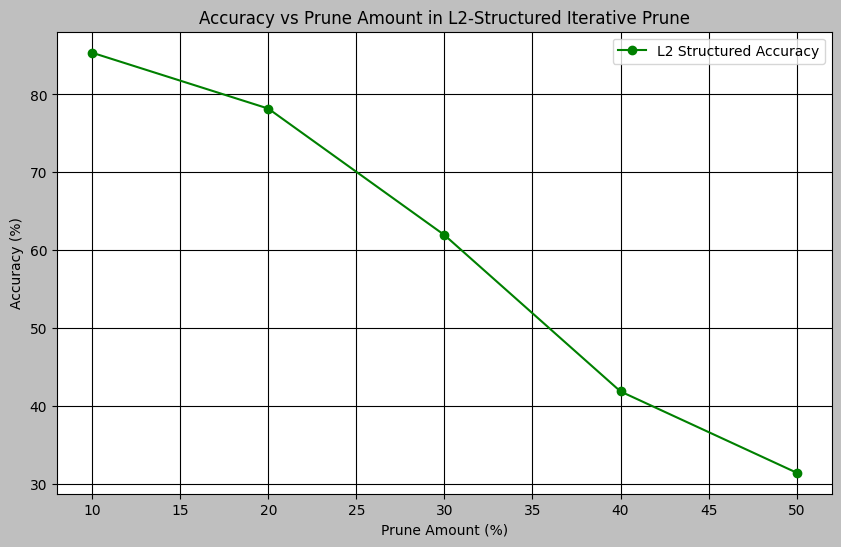

In [24]:
start_prune = 0.1
end_prune = 0.5
step_count = int((end_prune - start_prune) / 0.1) + 1
fine_tune_epochs = 3

model = copy.deepcopy(baseline_model)

accuracies = []
prune_levels = []

current_pruned = 0.0
target_pruned_list = [round(p, 2) for p in list(torch.arange(start_prune, end_prune + 0.001, 0.1).tolist())]

for target in target_pruned_list:
    remaining = 1.0 - current_pruned
    step_amount = (target - current_pruned) / remaining

    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            prune.ln_structured(module, name='weight', amount=step_amount, n=2, dim=0)

    current_pruned = target

    for epoch in range(fine_tune_epochs):
        train(1)

    acc = test(model)
    accuracies.append(acc)
    prune_levels.append(target * 100)
    print(f'L2 Structured Pruned to {target*100:.0f}%, Accuracy: {acc:.2f}%')

plt.figure(figsize=(10, 6))
plt.plot(prune_levels, accuracies, marker='o', linestyle='-', color='g', label='L2 Structured Accuracy')
plt.xlabel('Prune Amount (%)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Prune Amount in L2-Structured Iterative Prune')
plt.grid(True)
plt.legend()
plt.show()

Epoch 1/1 - Train Acc: 98.66%, Test Acc: 84.23%
Epoch 1/1 - Train Acc: 98.63%, Test Acc: 84.38%
Epoch 1/1 - Train Acc: 98.66%, Test Acc: 84.42%
L2 Structured Pruned to 10%, Accuracy: 84.42%
Epoch 1/1 - Train Acc: 89.14%, Test Acc: 76.99%
Epoch 1/1 - Train Acc: 89.14%, Test Acc: 77.17%
Epoch 1/1 - Train Acc: 89.28%, Test Acc: 77.06%
L2 Structured Pruned to 20%, Accuracy: 77.06%
Epoch 1/1 - Train Acc: 70.41%, Test Acc: 62.77%
Epoch 1/1 - Train Acc: 70.42%, Test Acc: 63.04%
Epoch 1/1 - Train Acc: 70.35%, Test Acc: 62.20%
L2 Structured Pruned to 30%, Accuracy: 62.20%
Epoch 1/1 - Train Acc: 44.68%, Test Acc: 40.88%
Epoch 1/1 - Train Acc: 44.61%, Test Acc: 40.85%
Epoch 1/1 - Train Acc: 44.79%, Test Acc: 40.83%
L2 Structured Pruned to 40%, Accuracy: 40.83%
Epoch 1/1 - Train Acc: 31.88%, Test Acc: 28.94%
Epoch 1/1 - Train Acc: 31.99%, Test Acc: 28.95%
Epoch 1/1 - Train Acc: 31.87%, Test Acc: 28.89%
L2 Structured Pruned to 50%, Accuracy: 28.89%


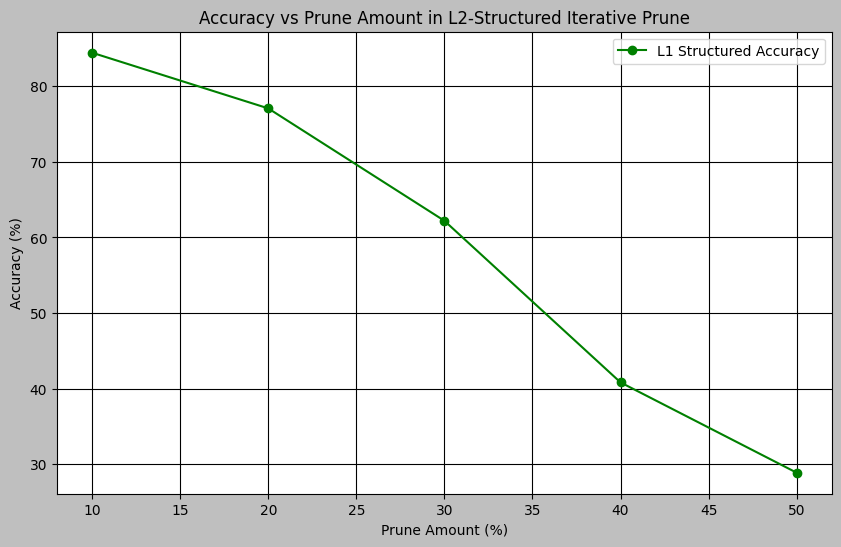

In [32]:
start_prune = 0.1
end_prune = 0.5
step_count = int((end_prune - start_prune) / 0.1) + 1
fine_tune_epochs = 3

model = copy.deepcopy(baseline_model)

accuracies = []
prune_levels = []

current_pruned = 0.0
target_pruned_list = [round(p, 2) for p in list(torch.arange(start_prune, end_prune + 0.001, 0.1).tolist())]

for target in target_pruned_list:
    remaining = 1.0 - current_pruned
    step_amount = (target - current_pruned) / remaining

    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            prune.ln_structured(module, name='weight', amount=step_amount, n=1, dim=0)

    current_pruned = target

    for epoch in range(fine_tune_epochs):
        train(1)

    acc = test(model)
    accuracies.append(acc)
    prune_levels.append(target * 100)
    print(f'L2 Structured Pruned to {target*100:.0f}%, Accuracy: {acc:.2f}%')

plt.figure(figsize=(10, 6))
plt.plot(prune_levels, accuracies, marker='o', linestyle='-', color='g', label='L1 Structured Accuracy')
plt.xlabel('Prune Amount (%)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Prune Amount in L2-Structured Iterative Prune')
plt.grid(True)
plt.legend()
plt.show()

L2 Structured Pruned to 10%, Accuracy: 83.92%
L2 Structured Pruned to 20%, Accuracy: 84.22%
L2 Structured Pruned to 30%, Accuracy: 83.07%
L2 Structured Pruned to 40%, Accuracy: 84.88%
L2 Structured Pruned to 50%, Accuracy: 83.94%


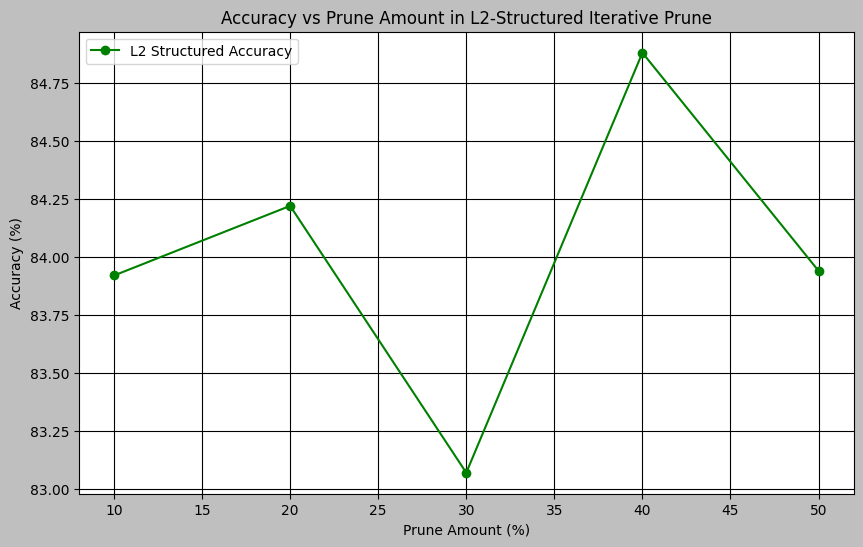

In [25]:
import torch
import torch.nn.utils.prune as prune
import torch.nn as nn
import copy
import matplotlib.pyplot as plt

start_prune = 0.1
end_prune = 0.5
step_count = int((end_prune - start_prune) / 0.1) + 1
fine_tune_epochs = 3

accuracies = []
prune_levels = []

def train(model, optimizer, scheduler, criterion, epochs=1):
    model.train()
    for epoch in range(epochs):
        correct, total = 0, 0
        running_loss = 0.0
        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)
            running_loss += loss.item() * inputs.size(0)
        scheduler.step()

def test(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)
    return 100. * correct / total

model = copy.deepcopy(baseline_model)
current_pruned = 0.0
target_pruned_list = [round(p, 2) for p in list(torch.arange(start_prune, end_prune + 0.001, 0.1).tolist())]

for target in target_pruned_list:
    remaining = 1.0 - current_pruned
    step_amount = (target - current_pruned) / remaining

    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            prune.ln_structured(module, name='weight', amount=step_amount, n=2, dim=0)

    current_pruned = target

    # حذف ماسک‌ها برای اعمال درست در مرحله بعد
    for module in model.modules():
        if isinstance(module, nn.Conv2d) and hasattr(module, 'weight_orig'):
            prune.remove(module, 'weight')

    # تعریف optimizer و scheduler جدید
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)

    train(model, optimizer, scheduler, criterion, epochs=fine_tune_epochs)
    acc = test(model)
    accuracies.append(acc)
    prune_levels.append(target * 100)
    print(f'L2 Structured Pruned to {target*100:.0f}%, Accuracy: {acc:.2f}%')

plt.figure(figsize=(10, 6))
plt.plot(prune_levels, accuracies, marker='o', linestyle='-', color='g', label='L2 Structured Accuracy')
plt.xlabel('Prune Amount (%)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Prune Amount in L2-Structured Iterative Prune')
plt.grid(True)
plt.legend()
plt.show()


L2 Structured Pruned to 10%, Accuracy: 83.50%
L2 Structured Pruned to 20%, Accuracy: 84.19%
L2 Structured Pruned to 30%, Accuracy: 82.68%
L2 Structured Pruned to 40%, Accuracy: 83.07%
L2 Structured Pruned to 50%, Accuracy: 85.38%


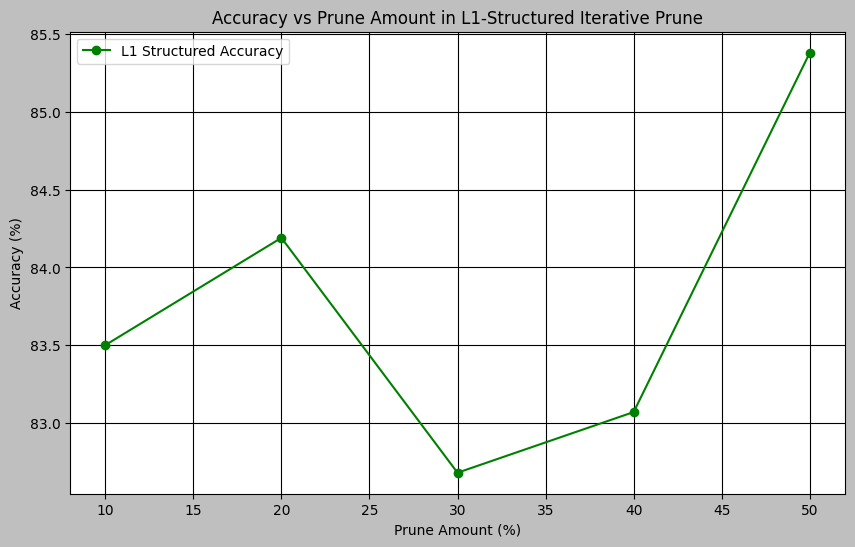

In [33]:
import torch
import torch.nn.utils.prune as prune
import torch.nn as nn
import copy
import matplotlib.pyplot as plt

start_prune = 0.1
end_prune = 0.5
step_count = int((end_prune - start_prune) / 0.1) + 1
fine_tune_epochs = 3

accuracies = []
prune_levels = []

def train(model, optimizer, scheduler, criterion, epochs=1):
    model.train()
    for epoch in range(epochs):
        correct, total = 0, 0
        running_loss = 0.0
        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)
            running_loss += loss.item() * inputs.size(0)
        scheduler.step()

def test(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)
    return 100. * correct / total

model = copy.deepcopy(baseline_model)
current_pruned = 0.0
target_pruned_list = [round(p, 2) for p in list(torch.arange(start_prune, end_prune + 0.001, 0.1).tolist())]

for target in target_pruned_list:
    remaining = 1.0 - current_pruned
    step_amount = (target - current_pruned) / remaining

    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            prune.ln_structured(module, name='weight', amount=step_amount, n=1, dim=0)

    current_pruned = target

    # حذف ماسک‌ها برای اعمال درست در مرحله بعد
    for module in model.modules():
        if isinstance(module, nn.Conv2d) and hasattr(module, 'weight_orig'):
            prune.remove(module, 'weight')

    # تعریف optimizer و scheduler جدید
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)

    train(model, optimizer, scheduler, criterion, epochs=fine_tune_epochs)
    acc = test(model)
    accuracies.append(acc)
    prune_levels.append(target * 100)
    print(f'L2 Structured Pruned to {target*100:.0f}%, Accuracy: {acc:.2f}%')

plt.figure(figsize=(10, 6))
plt.plot(prune_levels, accuracies, marker='o', linestyle='-', color='g', label='L1 Structured Accuracy')
plt.xlabel('Prune Amount (%)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Prune Amount in L1-Structured Iterative Prune')
plt.grid(True)
plt.legend()
plt.show()


در ابتدا با روش قبلی سعی کردیم کار رو جلو ببریم ولی به نظر نتایج درست نمی آمد سپس ابپتیمایزر رو برای شبکه هرس شده مجدد تنظیم کردیم با این کار چه با l2 و چه با l1 دقت تقریبا روی ۸۴ درصد است.

##Q4- نتیجه

در نهایت به نظر میاد مدل ساختار مند بهتره ولی تفاوتی بین l1,l2 مشاهده نشد

البته باید به این نکته توجه کرد که linear برعکس حالت غیر ساختار مند هرس نشده اما درکل به نظر بهتر می آید